In [2]:
#!pip install scispacy
#!pip install spacy==3.2
#!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bc5cdr_md-0.4.0.tar.gz
#!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.4.0/en_core_web_sm-3.4.0.tar.gz#egg=en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 972.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 kB 18.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 10.2 MB/s eta 0:00:00
  Using cached pybind11-2.6.1-py2.py3-none-any.whl (188 kB)
  Created wheel for nmslib: filename=nmslib-2.1.1-cp310-cp310-linux_x86_64.whl size=13547971 sha256=d2a019f5ead05f5001cdae75fb7fcd840333005e495c8950c8f8812e583217ff
  Stored in directory: /root/.cache/pip/wheels/21/1a/5d/4cc754a5b1a88405cad184b76f823897a63a8d19afcd4b9314
Successfully built nmslib
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.4
    Uninstalling scipy-1.11.4:
      Successfully uninstalled scipy-1.11.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour i

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
print(torch.cuda.is_available())
# device = torch.device("cpu")
# TODO: Uncomment the below line if you see True in the print statement
device = torch.device("cuda:0")

True


In [3]:
import scispacy
import spacy
import json
import spacy.cli
nlp = spacy.load("en_ner_bc5cdr_md")
import os
import string
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from typing import Dict, List

/usr/local/lib/python3.10/dist-packages/spacy/util.py:877: UserWarning: [W095] Model 'en_ner_bc5cdr_md' (0.4.0) was trained with spaCy v3.0 and may not be 100% compatible with the current version (3.4.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Read train json and CTR files

In [4]:
path_to_CT_json = "drive/MyDrive/training_data/CT json/"
file_name_to_CT_dict = {}  #eg : {'NCT00001832':{---CT json---}}

json_file_names = [filename for filename in os.listdir(path_to_CT_json) if filename.endswith('.json')]
for json_file_name in json_file_names:
    with open(os.path.join(path_to_CT_json, json_file_name)) as json_file:
        json_text = json.load(json_file)
        file_name_to_CT_dict[json_file_name[:-5]]= json_text

In [5]:
train_path = "drive/MyDrive/training_data/train.json"
with open(train_path) as json_file:
    train = json.load(json_file)

In [6]:
test_path = "drive/MyDrive/training_data/dev.json"
with open(test_path) as json_file:
    test = json.load(json_file)

## Initialize the text summarizer module

In [7]:
from transformers import pipeline

summarizer = pipeline("summarization", model="Falconsai/medical_summarization", device = 0)


def get_summarized_text(MEDICAL_DOCUMENT):
  return summarizer(MEDICAL_DOCUMENT, max_length=150, min_length=30, do_sample=False)[0]['summary_text']

## Convert json files to single dict

In [8]:
label_map = {"Contradiction":0,"Entailment":1}
def convert_to_dataset(json_data):
  dataset = []
  for i in json_data.keys():
    d ={}
    d['label'] = label_map[json_data[i]["Label"]]
    section_id = json_data[i]["Section_id"]

    d['hypothesis'] = json_data[i]["Statement"]

    primary_ct = file_name_to_CT_dict[(json_data[i]["Primary_id"])]

    if len(primary_ct[section_id]) > 512:
      print("greater")
      updated_primary_ct = get_summarized_text(" ".join(primary_ct[section_id]))
      d['primary_premise'] = updated_primary_ct
    else:
      d['primary_premise'] = " ".join(primary_ct[section_id])

    d['secondary_premise'] = ""

    if("Secondary_id" in json_data[i].keys()):
      secondary_ct = file_name_to_CT_dict[json_data[i]["Secondary_id"]]

      if len(secondary_ct[section_id]) > 512:
        updated_secondary_ct = get_summarized_text(" ".join(secondary_ct[section_id]))
        d['secondary_premise'] = updated_secondary_ct
      else:
        d['secondary_premise'] = " ".join(secondary_ct[section_id])

    dataset.append(d)

  return dataset

train_validate_dataset = convert_to_dataset(train)



In [9]:
train_dataset = train_validate_dataset[:1500]
validation_dataset = train_validate_dataset[1500:]
test_dataset = convert_to_dataset(test)

## Custom Preprocessing

In [10]:
import re
def truncate(match):
    number = float(match.group(0))
    truncated_number = round(number, 1)
    return str(truncated_number)

def replace_custom_punctuations_with_space(input_string, custom_punctuations):
    pattern = '[' + re.escape(''.join(custom_punctuations)) + ']'
    result = re.sub(pattern, ' ', input_string)
    return result

def replace_slash_between_number_and_word(input_string):
    pattern = r'(?<=\d)/(?=\w)'
    result = re.sub(pattern, ' ', input_string)
    return result

def add_space_between_word_and_number(input_string):
    pattern = re.compile(r'([a-zA-Z]+)(\d+)')
    result = re.sub(pattern, r'\1 \2', input_string)

    # Add space between number and word
    pattern = re.compile(r'(\d+)([a-zA-Z]+)')
    result = re.sub(pattern, r'\1 \2', result)

    return result

def remove_comma_between_numbers(input_string):
    pattern = re.compile(r'(\d+),(\d+)')
    result = re.sub(pattern, r'\1\2', input_string)
    return result

def initial_preprocessing(sentence):

    result = re.sub(r'(-?\d+\.\d+)', truncate, sentence)

    tokens = re.split( r'(?<=\w)-(?=\D)|(?<=\d)(/)(?=\d)', result)
    tokens = [i for i in tokens if i!=None ]
    tokens = " ".join(tokens)

    tokens = replace_slash_between_number_and_word(tokens)

    tokens = add_space_between_word_and_number(tokens)

    tokens = remove_comma_between_numbers(tokens)

    custom_punctuations = ['(', '=', '~',')','{','}','\\','+','[',']']  # Add your custom punctuations to replace here

    output_string = replace_custom_punctuations_with_space(tokens, custom_punctuations)

    return output_string

# Example usage:
input_sentence = "This is a sample sentence-with-minus between words but not-followed by numbers. -(2/3) 2/mg/g  100g gw100 3bananas 100,100"
result = initial_preprocessing(input_sentence)
print(result)

This is a sample sentence with minus between words but not followed by numbers. - 2 / 3  2 mg/g  100 g gw 100 3 bananas 100100


In [20]:
additional_stopwords = ["achieved", "administered", "adverse", "better", "both",
                        "between", "cannot", "case", "cases", "cohort", "cohorts",
                        "common", "confirmed", "depending", "diagnosed", "did",
                        "difference", "different", "do", "does", "each", "either",
                        "eligible", "event", "events", "every", "excluded", "experienced",
                        "group", "groups", "having", "higher", "included", "ineligible",
                        "intervention", "interventions", "least", "less", "lower", "many",
                        "may", "minimum", "more", "most", "must", "none", "number",
                        "observed", "occurred", "one", "outcome", "over", "part",
                        "participant", "participants", "participate", "participating",
                        "participation", "patient", "patients", "primary", "prior", "receive",
                        "received", "receiving", "recently", "record", "recorded", "reported",
                        "require", "required", "requires", "response", "results", "same", "secondary",
                        "several", "still", "study", "subjects", "suffered", "take", "treated",
                        "treatment", "trial", "types", "undergo", "unit", "use", "used", "uses",
                        "whereas", "who", "will","would"]

In [11]:
from typing import Dict, List, Optional, Tuple
from collections import Counter

import torch
import numpy as np
import spacy
import re

def replace_signs(text):
    text = text.replace(">=", "greater than or equal ")
    text = text.replace("=>", "greater than or equal ")
    text = text.replace("=<", "less than or equal ")
    text = text.replace("<=", "less than or equal ")
    text = text.replace(">", "greater than ")
    text = text.replace("<", "less than ")

    return text

def get_wordnet_pos(word):

    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].lower()
    tag_dict = {"a": wordnet.ADJ,
                "n": wordnet.NOUN,
                "v": wordnet.VERB,
                "r": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def clean_text(text):
    text = initial_preprocessing(text)
    doc_tokenizer = nlp(replace_signs(text))
    remove_stop_words = ([token.lemma_.strip().lower() for token in doc_tokenizer  if token.is_stop==False and token.text.strip()!=''])
    removed_punctuations = [i for i in remove_stop_words if i not in string.punctuation]
    preprocessed_tokens = [WordNetLemmatizer().lemmatize(i, get_wordnet_pos(i)) for i in removed_punctuations]
    return preprocessed_tokens

## Clean primary premise, secondary premise and hypothesis

In [12]:
from tqdm import tqdm
def tokenize(sentences: List[Dict]) -> List[List[str]]:

    tokenized_sentences = []
    i=0
    for texts in tqdm(sentences):
      hypothesis = texts["hypothesis"]
      primary_premise = texts["primary_premise"]
      secondary_premise = texts["secondary_premise"]

      #print("Previous", len(hypothesis.split(" ")), len(primary_premise.split(" ")), len(secondary_premise.split(" ")))
      if len(hypothesis.split(" ")) > 150:
        hypothesis = get_summarized_text(hypothesis)

      if len(primary_premise.split(" ")) > 150:
        primary_premise = get_summarized_text(primary_premise)

      if len(secondary_premise.split(" ")) > 150:
        secondary_premise = get_summarized_text(secondary_premise)

      #print("Updated", len(hypothesis.split(" ")), len(primary_premise.split(" ")), len(secondary_premise.split(" ")))
      #print("*"*50)
      clean_hypothesis = clean_text(hypothesis)
      clean_primary_premise = clean_text(primary_premise)
      clean_secondary_premise = clean_text(secondary_premise)
      label = texts['label']
      '''lemmatized = clean_hypothesis+['<SEP>']+clean_primary_premise+['<SEP>']+clean_secondary_premise
      lemmatized.append('<EOS>')
      lemmatized.insert(0, '<SOS>')'''

      lemmatized = {"premise": "primary trial " + " ".join(clean_primary_premise) + "secondary trial "+ " ".join(clean_secondary_premise), "hypothesis": " ".join(clean_hypothesis), "label": label}
      #lemmatized = {"premise": "primary trial " + primary_premise + "secondary trial "+ secondary_premise, "hypothesis": hypothesis, "label": label}
      #tokenized_sentences.append(" ".join(lemmatized))
      tokenized_sentences.append(lemmatized)

    return tokenized_sentences

def pad(batch: List[List[str]]) -> List[List[str]]:
    pad_symbol = "<PAD>"
    max_length = max(len(i) for i in batch)

    for b in range(len(batch)):
        num_of_paddings = max_length - len(batch[b])
        batch[b].extend([pad_symbol]*num_of_paddings)

    return batch

In [13]:
# create the vocabulary of the dataset: use both training and test sets here

SPECIAL_TOKENS = ['<UNK>', '<PAD>', '<SOS>', '<EOS>']

all_data = train_dataset + validation_dataset + test_dataset

tokenized_data = tokenize(all_data)

#vocab = sorted(set([w for ws in tokenized_data + [SPECIAL_TOKENS] for w in ws]))
#file = open('/content/drive/MyDrive/NLP Shared Task /voacb.txt','w')
#for item in vocab:
	#file.write(item+"\n")
#file.close()


  1%|▏         | 24/1900 [00:21<17:18,  1.81it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 1900/1900 [34:13<00:00,  1.08s/it]


In [14]:
# Install required libraries
# pip install torch torchvision transformers datasets

import torch
from torch.utils.data import DataLoader, Dataset
from transformers import T5Tokenizer, T5ForSequenceClassification, AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, AutoModelForSeq2SeqLM
#from datasets import load_dataset

## Batch tokenizer for BioLinkBert

In [15]:
# Nothing to do for this class!

class BatchTokenizer:
    """Tokenizes and pads a batch of input sentences."""

    def __init__(self, model_name='michiyasunaga/BioLinkBERT-base'):
        """Initializes the tokenizer

        Args:
            pad_symbol (Optional[str], optional): The symbol for a pad. Defaults to "<P>".
        """
        self.hf_tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model_name = model_name

    def get_sep_token(self,):
        return self.hf_tokenizer.sep_token

    def __call__(self, prem_batch: List[str], hyp_batch: List[str]) -> List[List[str]]:
        """Uses the huggingface tokenizer to tokenize and pad a batch.

        We return a dictionary of tensors per the huggingface model specification.

        Args:
            batch (List[str]): A List of sentence strings

        Returns:
            Dict: The dictionary of token specifications provided by HuggingFace
        """
        # The HF tokenizer will PAD for us, and additionally combine
        # The two sentences deimited by the [SEP] token.
        enc = self.hf_tokenizer(
            prem_batch,
            hyp_batch,
            padding=True,
            return_token_type_ids=False,
            max_length=512,
            return_tensors='pt'
        )

        return enc


# HERE IS AN EXAMPLE OF HOW TO USE THE BATCH TOKENIZER
tokenizer = BatchTokenizer()
x = tokenizer(*[["this is the first premise", "This is the second premise"], ["This is first hypothesis", "This is the second hypothesis"]])
print(x)
tokenizer.hf_tokenizer.batch_decode(x["input_ids"])



{'input_ids': tensor([[    2,  1805,  1744,  1680,  2389, 26770,     3,  1805,  1744,  2389,
          4405,     3,     0],
        [    2,  1805,  1744,  1680,  2702, 26770,     3,  1805,  1744,  1680,
          2702,  4405,     3]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2632: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


['[CLS] this is the first premise [SEP] this is first hypothesis [SEP] [PAD]',
 '[CLS] this is the second premise [SEP] this is the second hypothesis [SEP]']

In [16]:
def generate_pairwise_input(dataset: List[Dict]) -> (List[str], List[str], List[int]):
    """
    TODO: group all premises and corresponding hypotheses and labels of the datapoints
    a datapoint as seen earlier is a dict of premis, hypothesis and label
    """
    premises = []
    hypothesis = []
    labels = []
    for x in dataset:
        premises.append(x['premise'])
        hypothesis.append(x['hypothesis'])
        labels.append(x['label'])

    return premises, hypothesis, labels

In [17]:
train_dataset = tokenized_data[0:1700]
validation_dataset = tokenized_data[1700:]
test_dataset = tokenized_data[1700:]

In [18]:
train_premises, train_hypotheses, train_labels = generate_pairwise_input(train_dataset)
validation_premises, validation_hypotheses, validation_labels = generate_pairwise_input(validation_dataset)
test_premises, test_hypotheses, test_labels = generate_pairwise_input(test_dataset)

## Batching the train, validation and test data

In [19]:
def chunk(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def chunk_multi(lst1, lst2, n):
    for i in range(0, len(lst1), n):
        yield lst1[i: i + n], lst2[i: i + n]

batch_size = 8

# Notice that since we use huggingface, we tokenize and
# encode in all at once!
tokenizer = BatchTokenizer()
train_input_batches = [b for b in chunk_multi(train_premises, train_hypotheses, batch_size)]
# Tokenize + encode
train_input_batches = [tokenizer(*batch) for batch in train_input_batches]

In [27]:
def encode_labels(labels: List[int]) -> torch.FloatTensor:
    """Turns the batch of labels into a tensor

    Args:
        labels (List[int]): List of all labels in the batch

    Returns:
        torch.FloatTensor: Tensor of all labels in the batch
    """
    return torch.LongTensor([int(l) for l in labels])


train_label_batches = [b for b in chunk(train_labels, batch_size)]
train_label_batches = [encode_labels(batch) for batch in train_label_batches]

## NLIClassfier for BioLink-Bert for fine-tuning

In [34]:
class NLIClassifier(torch.nn.Module):
    def __init__(self, output_size: int, hidden_size: int, model_name='michiyasunaga/BioLinkBERT-base'):
        super().__init__()
        self.output_size = output_size
        self.hidden_size = hidden_size

        # Initialize BERT, which we use instead of a single embedding layer.
        self.bert = BertModel.from_pretrained(model_name)

        for param in self.bert.parameters():
             param.requires_grad = False

        self.bert_hidden_dimension = self.bert.config.hidden_size
        self.hidden_layer = torch.nn.Linear(self.bert_hidden_dimension, self.hidden_size)
        self.relu = torch.nn.ReLU()

        self.classifier = torch.nn.Linear(self.hidden_size, self.output_size)
        self.log_softmax = torch.nn.LogSoftmax(dim=2)

    def encode_text(
        self,
        symbols: Dict
    ) -> torch.Tensor:
        """Encode the (batch of) sequence(s) of token symbols BERT.
            Then, get CLS represenation.

        Args:
            symbols (Dict): The Dict of token specifications provided by the HuggingFace tokenizer

        Returns:
            torch.Tensor: CLS token embedding
        """

        encoded_sequence = self.bert(**symbols)
        cls_token = encoded_sequence.last_hidden_state[:, 0, :].unsqueeze(1)
        return cls_token

    def forward(
        self,
        symbols: Dict,
    ) -> torch.Tensor:
        """_summary_

        Args:
            symbols (Dict): The Dict of token specifications provided by the HuggingFace tokenizer

        Returns:
            torch.Tensor: _description_
        """
        encoded_sents = self.encode_text(symbols)
        output = self.hidden_layer(encoded_sents)
        output = self.relu(output)
        output = self.classifier(output)
        return self.log_softmax(output)

In [28]:
# For making predictions at test time
def predict(model: torch.nn.Module, sents: torch.Tensor) -> List:
    logits = model(sents.to(device))
    return list(torch.Tensor.cpu(torch.argmax(logits, axis=2).squeeze()).numpy())

## Evaluation Metrics

In [29]:
import numpy as np
from numpy import sum as t_sum
from numpy import logical_and


def precision(predicted_labels, true_labels, which_label=1):
    """
    Precision is True Positives / All Positives Predictions
    """
    pred_which = np.array([pred == which_label for pred in predicted_labels])
    true_which = np.array([lab == which_label for lab in true_labels])
    denominator = t_sum(pred_which)
    if denominator:
        return t_sum(logical_and(pred_which, true_which))/denominator
    else:
        return 0.


def recall(predicted_labels, true_labels, which_label=1):
    """
    Recall is True Positives / All Positive Labels
    """
    pred_which = np.array([pred == which_label for pred in predicted_labels])
    true_which = np.array([lab == which_label for lab in true_labels])
    denominator = t_sum(true_which)
    if denominator:
        return t_sum(logical_and(pred_which, true_which))/denominator
    else:
        return 0.


def f1_score(
    predicted_labels: List[int],
    true_labels: List[int],
    which_label: int
):
    """
    F1 score is the harmonic mean of precision and recall
    """
    P = precision(predicted_labels, true_labels, which_label=which_label)
    R = recall(predicted_labels, true_labels, which_label=which_label)

    if P and R:
        return 2*P*R/(P+R)
    else:
        return 0.


def macro_f1(
    predicted_labels: List[int],
    true_labels: List[int],
    possible_labels: List[int],
    label_map=None
):
    converted_prediction = [label_map[int(x)] for x in predicted_labels] if label_map else predicted_labels
    scores = [f1_score(converted_prediction, true_labels, l) for l in possible_labels]
    # Macro, so we take the uniform avg.
    return sum(scores) / len(scores)


In [30]:
import matplotlib.pyplot as plt


## Training loop with hyperparameters

In [35]:
def training_loop(
    num_epochs,
    train_features,
    train_labels,
    dev_sents,
    dev_labels,
    optimizer,
    model,
):
    print("Training...")
    loss_func = torch.nn.NLLLoss()
    batches = list(zip(train_features, train_labels))
    random.shuffle(batches)
    f1_scores = []
    for i in range(num_epochs):
        losses = []
        for features, labels in tqdm(batches):
            # Empty the dynamic computation graph
            optimizer.zero_grad()
            preds = model(features.to(device)).squeeze(1)
            loss = loss_func(preds, labels.to(device))
            # Backpropogate the loss through our model
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        print(f"epoch {i}, loss: {sum(losses)/len(losses)}")
        # Estimate the f1 score for the development set
        print("Evaluating dev...")
        all_preds = []
        all_labels = []
        for sents, labels in tqdm(zip(dev_sents, dev_labels), total=len(dev_sents)):
            pred = predict(model, sents)
            all_preds.extend(pred)
            all_labels.extend(list(labels.cpu().numpy()))

        dev_f1 = macro_f1(all_preds, all_labels, possible_labels=[0,1])
        f1_scores.append(dev_f1)
        print(f"Dev F1 {dev_f1}")

    plt.plot(f1_scores)
    plt.show()

    print("Done training!")
    # Return the trained model
    return model

In [32]:
from transformers import BertModel
import random

config.json:   0%|          | 0.00/559 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2632: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Training...


100%|██████████| 213/213 [00:20<00:00, 10.38it/s]


epoch 0, loss: 0.6957057941127831
Evaluating dev...


100%|██████████| 25/25 [00:02<00:00, 10.70it/s]


Dev F1 0.5192307692307692


100%|██████████| 213/213 [00:20<00:00, 10.32it/s]


epoch 1, loss: 0.6942554776657355
Evaluating dev...


100%|██████████| 25/25 [00:02<00:00, 10.63it/s]


Dev F1 0.5013975976429704


100%|██████████| 213/213 [00:20<00:00, 10.20it/s]


epoch 2, loss: 0.693650203131734
Evaluating dev...


100%|██████████| 25/25 [00:02<00:00, 10.51it/s]


Dev F1 0.5095932657549482


100%|██████████| 213/213 [00:21<00:00, 10.08it/s]


epoch 3, loss: 0.6931214872660212
Evaluating dev...


100%|██████████| 25/25 [00:02<00:00, 10.42it/s]


Dev F1 0.5105830116804158


100%|██████████| 213/213 [00:21<00:00, 10.00it/s]


epoch 4, loss: 0.6926708912625559
Evaluating dev...


100%|██████████| 25/25 [00:02<00:00, 10.27it/s]


Dev F1 0.5114703734481629


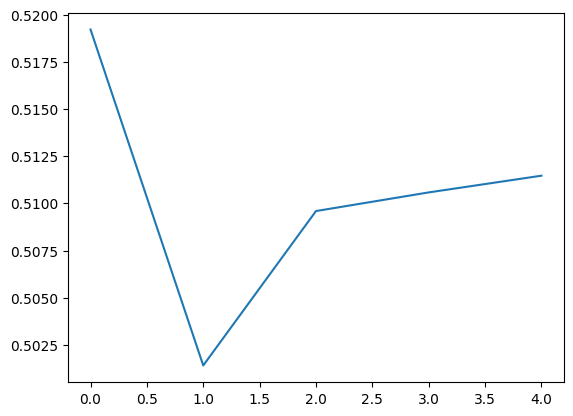

Done training!


NLIClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28895, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

In [36]:
# You can increase epochs if need be
epochs = 5

# TODO: Find a good learning rate and hidden size
LR = 2e-05
hidden_size = 512
possible_labels = set(train_labels)
model = NLIClassifier(output_size=len(possible_labels), hidden_size=hidden_size)
model
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), LR, weight_decay=0.1)

batch_tokenizer = BatchTokenizer()

validation_input_batches = [b for b in chunk_multi(validation_premises, validation_hypotheses, batch_size)]

# Tokenize + encode
validation_input_batches = [batch_tokenizer(*batch) for batch in validation_input_batches]
validation_batch_labels = [b for b in chunk(validation_labels, batch_size)]
validation_batch_labels = [encode_labels(batch) for batch in validation_batch_labels]

training_loop(
    epochs,
    train_input_batches,
    train_label_batches,
    validation_input_batches,
    validation_batch_labels,
    optimizer,
    model,
)

In [37]:
# TODO: Get a final macro F1 on the test set.
# You should be able to mimic what we did with the validaiton set.
test_input_batches = [b for b in chunk_multi(test_premises, test_hypotheses, batch_size)]

# Tokenize + encode
test_input_batches = [batch_tokenizer(*batch) for batch in test_input_batches]
test_batch_labels = [b for b in chunk(test_labels, batch_size)]
test_batch_labels = [encode_labels(batch) for batch in test_batch_labels]

test_preds = []
test_labels = []
for sents, labels in tqdm(zip(test_input_batches, test_batch_labels), total=len(test_input_batches)):
    pred = predict(model, sents)
    test_preds.extend(pred)
    test_labels.extend(list(labels.cpu().numpy()))

dev_f1 = macro_f1(test_preds, test_labels, possible_labels=[0,1])
print(f"Test F1 {dev_f1}")

100%|██████████| 25/25 [00:02<00:00, 10.18it/s]

Test F1 0.5114703734481629


In [38]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, test_preds))

              precision    recall  f1-score   support

           0       0.52      0.43      0.47       100
           1       0.51      0.60      0.55       100

    accuracy                           0.52       200
   macro avg       0.52      0.52      0.51       200
weighted avg       0.52      0.52      0.51       200



## Experiments with BiomedNLP-PubMedBERT

In [40]:
##########ALTERNATE METHOD#############
!pip install datasets
!pip install accelerate -U
#!pip install transformers -U
#!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 4.2 MB/s eta 0:00:00


In [27]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from datasets import Dataset
from torch.utils.data import DataLoader
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader
import torch
import transformers
transformers.logging.set_verbosity_error()



## Creation of custom dataset

In [28]:

class CustomDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        encoding = self.tokenizer(
            item['premise'],
            item['hypothesis'],
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        encoding['label'] = torch.tensor(item['label'], dtype=torch.long)
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'token_type_ids': encoding['token_type_ids'].squeeze(),
            'labels': encoding['label']
        }

In [23]:
# Load the pre-trained PubMedBERT model and tokenizer
model_name = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
# Create instances of the datasets and dataloaders
train_dataset_ = CustomDataset(train_dataset, tokenizer)
val_dataset_ = CustomDataset(validation_dataset, tokenizer)

train_dataloader = DataLoader(train_dataset_, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset_, batch_size=8, shuffle=False)


## Training Loop on Train and Validation set

In [29]:



# Define training arguments
training_args = TrainingArguments(
    output_dir="./pubmedbert-finetuned",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    save_steps=5000,
    save_total_limit=2,
    evaluation_strategy="steps",
    eval_steps=500,
    logging_dir="./logs",
    logging_steps=100,
    learning_rate=2e-5,
    gradient_accumulation_steps=1,
    report_to="tensorboard",
    load_best_model_at_end=True
)

# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=None,
    train_dataset=train_dataset_,
    eval_dataset=val_dataset_,
)

# Fine-tune the model
trainer.train()

# Evaluate the fine-tuned model
results = trainer.evaluate()

# Print the evaluation results
print(results)



{'loss': 0.6786, 'learning_rate': 1.6870109546165886e-05, 'epoch': 0.47}
{'loss': 0.7196, 'learning_rate': 1.374021909233177e-05, 'epoch': 0.94}
{'loss': 0.704, 'learning_rate': 1.0610328638497653e-05, 'epoch': 1.41}
{'loss': 0.6971, 'learning_rate': 7.480438184663538e-06, 'epoch': 1.88}
{'loss': 0.699, 'learning_rate': 4.350547730829422e-06, 'epoch': 2.35}
{'eval_loss': 0.6905478835105896, 'eval_runtime': 1.6569, 'eval_samples_per_second': 120.708, 'eval_steps_per_second': 15.088, 'epoch': 2.35}
{'loss': 0.696, 'learning_rate': 1.2206572769953053e-06, 'epoch': 2.82}
{'train_runtime': 141.6011, 'train_samples_per_second': 36.017, 'train_steps_per_second': 4.513, 'train_loss': 0.6988333491652224, 'epoch': 3.0}
{'eval_loss': 0.6898730397224426, 'eval_runtime': 1.6591, 'eval_samples_per_second': 120.545, 'eval_steps_per_second': 15.068, 'epoch': 3.0}
{'eval_loss': 0.6898730397224426, 'eval_runtime': 1.6591, 'eval_samples_per_second': 120.545, 'eval_steps_per_second': 15.068, 'epoch': 3.0}

In [35]:
from sklearn.metrics import precision_recall_fscore_support, classification_report


In [31]:
y_pred = np.argmax(trainer.evaluation_loop(dataloader=val_dataloader, description="eval")[0], axis=1)

In [32]:
y_true = trainer.evaluation_loop(dataloader=val_dataloader, description="eval")[1]

In [33]:

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

Precision: 0.4756, Recall: 0.8478, F1 Score: 0.6094


In [36]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.20      0.31        54
           1       0.48      0.85      0.61        46

    accuracy                           0.50       100
   macro avg       0.54      0.53      0.46       100
weighted avg       0.55      0.50      0.45       100



## Evaluation on test set

In [38]:
test_dataset_ = CustomDataset(test_dataset, tokenizer)
test_dataloader = DataLoader(test_dataset_, batch_size=8, shuffle=False)

In [39]:
# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=None,
    train_dataset=train_dataset_,
    eval_dataset=test_dataset_,
)

# Fine-tune the model
trainer.train()

# Evaluate the fine-tuned model
results = trainer.evaluate()

{'loss': 0.5607, 'learning_rate': 1.6870109546165886e-05, 'epoch': 0.47}
{'loss': 0.6842, 'learning_rate': 1.374021909233177e-05, 'epoch': 0.94}
{'loss': 0.6602, 'learning_rate': 1.0610328638497653e-05, 'epoch': 1.41}
{'loss': 0.6604, 'learning_rate': 7.480438184663538e-06, 'epoch': 1.88}
{'loss': 0.6509, 'learning_rate': 4.350547730829422e-06, 'epoch': 2.35}
{'eval_loss': 0.6791951060295105, 'eval_runtime': 1.9083, 'eval_samples_per_second': 104.807, 'eval_steps_per_second': 13.101, 'epoch': 2.35}
{'loss': 0.6611, 'learning_rate': 1.2206572769953053e-06, 'epoch': 2.82}
{'train_runtime': 143.4847, 'train_samples_per_second': 35.544, 'train_steps_per_second': 4.453, 'train_loss': 0.6472030723225529, 'epoch': 3.0}
{'eval_loss': 0.6959329843521118, 'eval_runtime': 1.7293, 'eval_samples_per_second': 115.656, 'eval_steps_per_second': 14.457, 'epoch': 3.0}


In [40]:
y_pred = np.argmax(trainer.evaluation_loop(dataloader=test_dataloader, description="eval")[0], axis=1)
y_true = trainer.evaluation_loop(dataloader=test_dataloader, description="eval")[1]

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

Precision: 0.4800, Recall: 0.7826, F1 Score: 0.5950


In [41]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.28      0.38        54
           1       0.48      0.78      0.60        46

    accuracy                           0.51       100
   macro avg       0.54      0.53      0.49       100
weighted avg       0.54      0.51      0.48       100



In [ ]:
# Save the fine-tuned model
trainer.save_model("./pubmedbert-finetuned")
